In [523]:
import sys
sys.path.append("/home/akdiaz/Documents/CASA_releases/analysis_scripts")
import analysisUtils as au
from astropy import units as u
import numpy as np
import parameters as par
from astropy import units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt 
from matplotlib import rc
from uncertainties import ufloat
from uncertainties.umath import *

# Proper motions

In [308]:
def proper_motions(file, label, color, dec):
    '''Does a fit to the proper motion and generates two plots. File and label are lists (one component per source).'''
    data = [np.loadtxt(f, skiprows=1, usecols = [0,1,2,3,4]) for f in file]
    time=[]
    RA=[]
    E_RA=[]
    DEC=[]
    E_DEC=[]
    RA_fit=[]
    DEC_fit=[]
    label_AR=[]
    label_DEC=[]
    label_AR_final=[]
    label_DEC_final=[]
    for d in data:
        time.append([i[0] for i in d])
        RA.append([i[1] for i in d])
        E_RA.append([i[2] for i in d])
        DEC.append([i[3] for i in d])
        E_DEC.append([i[4] for i in d])
        time_fit = np.linspace(min(time[-1]),max(time[-1]),10)
        # lets fit linear for AR (a*t+b)
        parRA, varRA = np.polyfit(time[-1], RA[-1], 1, w=1/np.array(E_RA[-1]), cov=True)
        aRA = parRA[0]
        bRA = parRA[1]
        RA_fit.append(aRA*time_fit+bRA)
        E_aRA = np.sqrt(varRA[0,0])
        E_bRA = np.sqrt(varRA[1,1])
        # lets fit linear for DEC (a*t+b)
        parDEC, varDEC = np.polyfit(time[-1], DEC[-1], 1, w=1/np.array(E_DEC[-1]), cov=True)
        aDEC = parDEC[0]
        bDEC = parDEC[1]
        DEC_fit.append(aDEC*time_fit+bDEC)
        E_aDEC = np.sqrt(varDEC[0,0])
        E_bDEC = np.sqrt(varDEC[1,1])
        # labels
        label_AR.append(f': $\mu_\\alpha$ Cos $\\delta$ = {round(aRA*15*1000*np.cos(dec),1)}$\pm${round(E_aRA*15*1000*np.cos(dec),1)} mas/yr')
        label_DEC.append(f': $\mu_\\delta$ = {round(aDEC*1000,1)}$\pm${round(E_aDEC*1000,1)} mas/yr')
        print(aRA,E_aRA)
        print(aDEC,E_aDEC)
    # do the AR plot
    plt.figure(figsize=(15,10))
    rc('xtick', labelsize=15) 
    rc('ytick', labelsize=15)
    plt.legend(fontsize=18)
    plt.xlabel('Epoch (yr)',fontsize=20)
    plt.ylabel('RA (s)',fontsize=20)
    pp = []
    for i,_ in enumerate(data):
        p = plt.errorbar(time[i], RA[i], xerr=None,yerr=E_RA[i], fmt='o'+color[i], capsize=3, ms=10)
        pp.append(p[0])
        plt.plot(time_fit, RA_fit[i],'--'+color[i])
        label_AR_final.append(label[i]+label_AR[i])
    plt.legend(pp, label_AR_final,fontsize=18)
    plt.savefig('AR.png',bbox='tight')
    # do the DEC plot
    plt.figure(figsize=(15,10))
    #rc('xtick', labelsize=15) 
    #rc('ytick', labelsize=15)
    plt.xlabel('Epoch (yr)',fontsize=20)
    plt.ylabel('DEC (Arcsec)',fontsize=20)
    pp = []
    for i,_ in enumerate(data):
        p = plt.errorbar(time[i], DEC[i], xerr=None,yerr=E_DEC[i], fmt='o'+color[i],capsize=3,ms=10)
        pp.append(p[0])
        plt.plot(time_fit, DEC_fit[i],'--'+color[i])
        label_DEC_final.append(label[i]+label_DEC[i])
    plt.legend(pp, label_DEC_final, fontsize=18)
    plt.savefig('DEC.png',bbox='tight')

In [524]:
def plot_movements(file1,file2):
    '''Plots the distance and PA between sources as a function of time.'''
    data1 = np.loadtxt(file1, skiprows=1, usecols = [0,1,2,3,4,5,6,7,8])
    data2 = np.loadtxt(file2, skiprows=1, usecols = [0,1,2,3,4,5,6,7,8])
    time1 = [i[0] for i in data1]
    time2 = [i[0] for i in data2] 
    if time1 == time2:
        ar1 = [ufloat((i[1]*3600+i[2]*60+i[3])*15,i[4]*15) for i in data1] #in arcsec
        ar2 = [ufloat((i[1]*3600+i[2]*60+i[3])*15,i[4]*15) for i in data2]#in arcsec
        dec1 = [ufloat(i[5]*3600+i[6]*60+i[7], i[8]) for i in data1] #in arcsec
        dec2 = [ufloat(i[5]*3600+i[6]*60+i[7], i[8]) for i in data2] #in arcsec
        sep = [sqrt(((a2-a1)*cos(d1/3600*np.pi/180))**2+(d2-d1)**2) for a1,a2,d1,d2 in zip(ar1,ar2,dec1,dec2)] #in arcsec
        pa = [90-asin((d2-d1)/s)*180/np.pi for d1,d2,s in zip(dec1,dec2,sep)] #in degrees
        sep_value = [i.n for i in sep]
        sep_error = [i.s for i in sep]
        pa_value = [i.n for i in pa]
        pa_error = [i.s for i in pa]
        #coor1 = [f'{int(i[1])}:{int(i[2])}:{i[3]} {int(i[5])}:{int(i[6])}:{i[7]}' for i in data1]
        #coor2 = [f'{int(i[1])}:{int(i[2])}:{i[3]} {int(i[5])}:{int(i[6])}:{i[7]}' for i in data2]
        #source_1 = [SkyCoord(c, frame='fk5', unit=(u.hourangle, u.deg)) for c in coor1]
        #source_2 = [SkyCoord(c, frame='fk5', unit=(u.hourangle, u.deg)) for c in coor2]
        #sep = [s1.separation(s2).arcsec for s1,s2 in zip(source_1,source_2)]
        #pa = [s1.position_angle(s2).deg for s1,s2 in zip(source_1,source_2)]
        # do the sep plot
        plt.figure(figsize=(15,10))
        rc('xtick', labelsize=15) 
        rc('ytick', labelsize=15)
        plt.xlabel('Epoch (yr)',fontsize=20)
        plt.ylabel('Separation (Arcsec)',fontsize=20)
        plt.errorbar(time1, sep_value, xerr=None,yerr=sep_error, fmt='-ob', capsize=3, ms=10)
        #plt.plot(time1, sep,'o-b')
        plt.savefig('sep.png',bbox='tight')
        # do the pa plot
        plt.figure(figsize=(15,10))
        rc('xtick', labelsize=15) 
        rc('ytick', labelsize=15)
        plt.xlabel('Epoch (yr)',fontsize=20)
        plt.ylabel('Position Angle (Degree)',fontsize=20)
        plt.errorbar(time1, pa_value, xerr=None,yerr=pa_error, fmt='-or', capsize=3, ms=10)
        #plt.plot(time1, pa,'o-r')
        plt.savefig('pa.png',bbox='tight')
        print(sep)
        print(pa)
    else:
        print('The epochs of the coordinates most be equal for both sources. Check them.')
        print(time1)
        print(time2)

[0.2758508314296745+/-0.03130238795745985, 0.34062318359129157+/-0.034131308308462054, 0.2990979290761723+/-0.03018526685936921, 0.2955666730535078+/-0.012699426201899566, 0.2924344315740842+/-0.012693558040023497, 0.29746861703291905+/-0.012692566751339828, 0.2833941948911687+/-0.013630102519761857, 0.29748039500595985+/-0.016419786471075136, 0.2962794016858921+/-0.012693528507669433]
[77.4372416119113+/-7.478716955286465, 78.14089715380987+/-6.687889819906808, 99.62327843347533+/-6.647840604933905, 86.12002305088271+/-2.7402404295384706, 88.43238901411958+/-2.7706234584291054, 89.42215668339273+/-2.723906386310353, 91.01093729866895+/-3.291049456542109, 89.22956259088967+/-3.6997032050583343, 91.54726231293996+/-2.734672851253834]


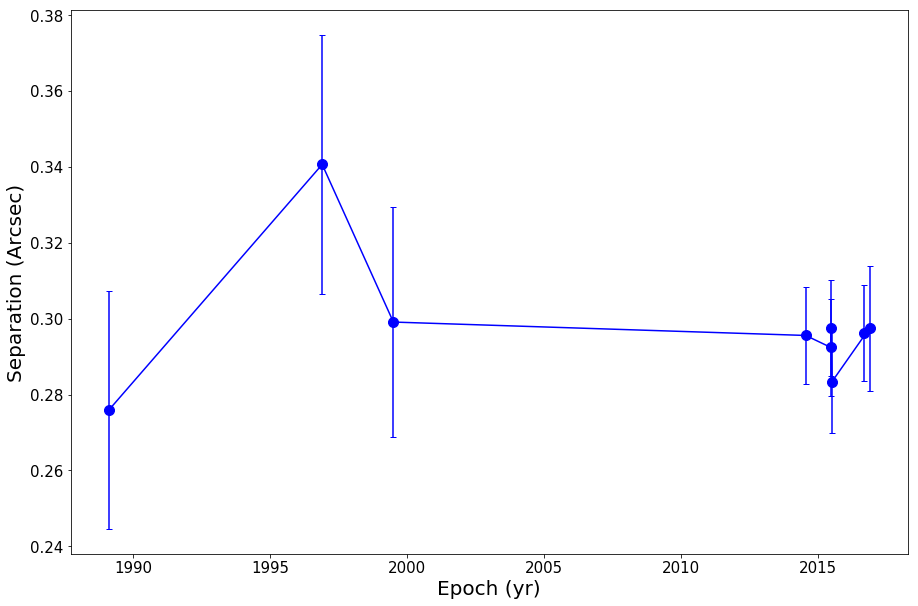

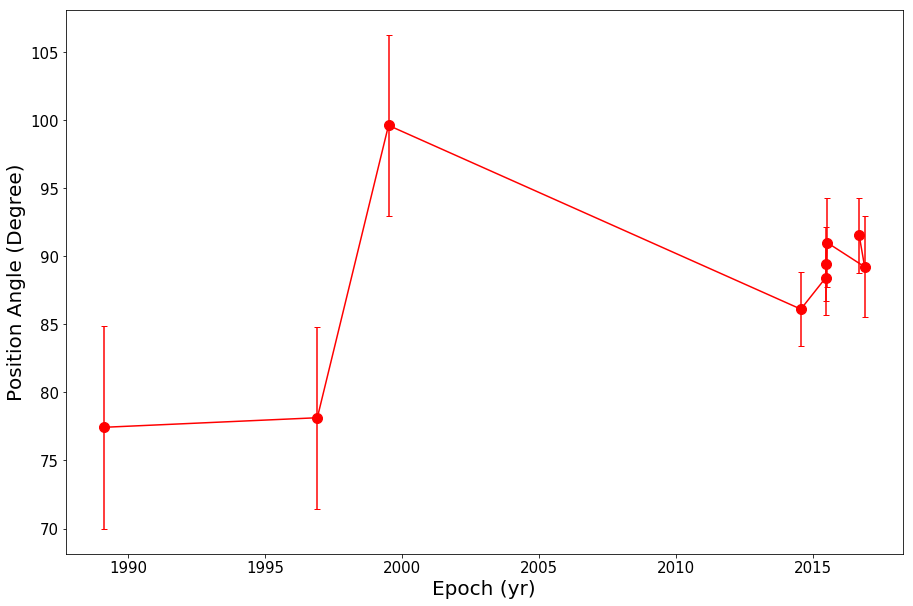

In [525]:
data_in='/home/akdiaz/Documents/Trabajo/SVS13/Images/VLA/proper motions/'
file_A = data_in + 'pm-A-coord.dat'
file_B = data_in + 'pm-B-coord.dat'
plot_movements(file_A, file_B)

No handles with labels found to put in legend.


0.000624353574458986 4.799907079650316e-05
-0.00914134027454376 0.000428308499673681
0.0005982337527484238 2.682231770211885e-05
-0.010496046186108821 0.0005103206729178722


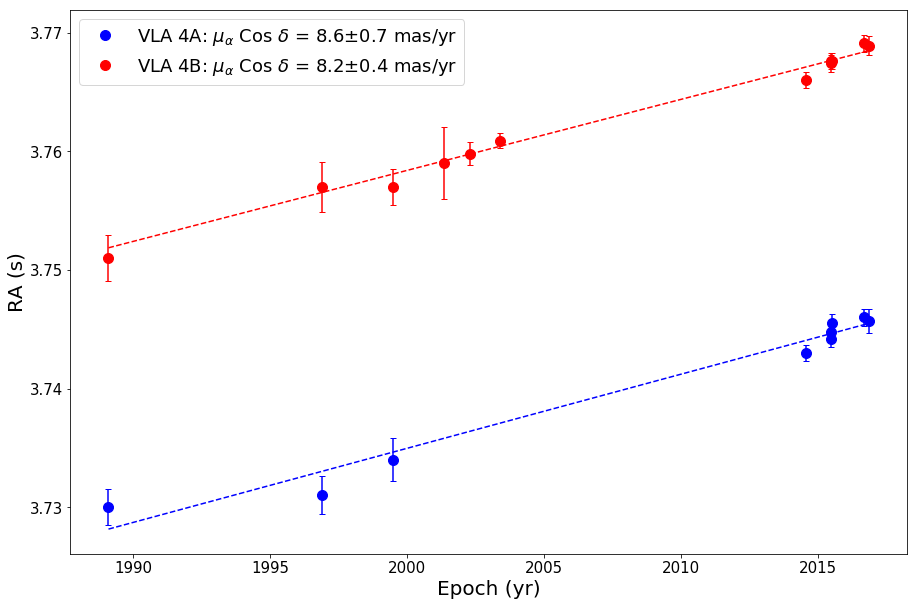

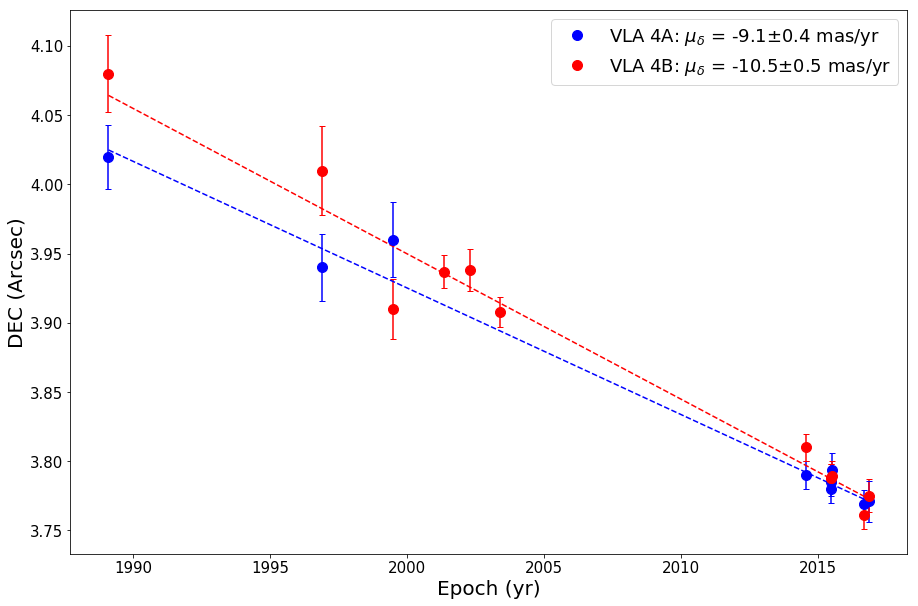

In [309]:
data_in='/home/akdiaz/Documents/Trabajo/SVS13/Images/VLA/proper motions/'
file_A = data_in + 'pm-A-best.dat'
file_B = data_in + 'pm-B-best.dat'
proper_motions([file_A, file_B],['VLA 4A', 'VLA 4B'],['b','r'],31)

# Optical position

In [268]:
def coordinates_new_epoch(ar,dec,pmar,pmdec,epoch1,epoch2):
    ''' Calculates the coordinates at a especific epoch2 using the proper motions pmar, pmdec, 
    from the coordinates (ICRS) ar, dec taken at epoch1 .
    Input: ar, dec in degrees; pmar, pmdec in mas; epoch1, epoch2 in years.
    Output: new_ar, new_dec in degress'''
    f = (epoch2-epoch1)/1000/3600
    inc_ar = pmar*f
    inc_dec = pmdec*f
    new_ar = ar + inc_ar
    new_dec = dec + inc_dec
    return new_ar, new_dec

In [269]:
def separation(ar, dec, new_arc, new_dec):
    'Returns the projected separation in arcsec between to coordinates in ICRS'
    c_icrs = SkyCoord(ar, dec, frame='icrs', unit='deg')
    c_icrs_new = SkyCoord(new_ar, new_dec, frame='icrs', unit='deg')
    sep = c_icrs.separation(c_icrs_new)
    return sep.arcsec

In [270]:
ar=52.265707466745944 #deg
dec=31.267707198461785 #deg
#ar_err = 0.5026056031603101 #mas
#dec_err = 0.31342583907522475 #mas
pmar = 10.751250164259192 #mas/yr
pmdec = -13.75931971408278
#pmar_err = 0.7515952479133767
#pmdec_err = 0.631270289616431
gaia_epoch = 2015.5
#VLA_epochB_Ka = 2015.123
#VLA_epochB_Q = 2015.181
VLA_epochA_X = 2016.893
VLA_epochA_K = 2015.489
VLA_epochA_Ka = 2015.516
VLA_epochA_Q = 2015.470
ALMA_hr = 2016.692
#ALMA_lr = 2016.899

In [271]:
epochs = [gaia_epoch, VLA_epochA_X, VLA_epochA_K, VLA_epochA_Ka, VLA_epochA_Q,ALMA_hr]
new_ar = []
new_dec = []
for new_epoch in epochs:
    a,d = coordinates_new_epoch(ar,dec,pmar,pmdec,gaia_epoch,new_epoch)
    new_ar.append(a)
    new_dec.append(d)

In [272]:
#separation between epochs
separation(ar,dec,new_ar,new_dec)

array([0.        , 0.02304851, 0.00018201, 0.00026474, 0.00049638,
       0.01972277])

In [273]:
new_coord = zip(new_ar,new_dec)
radec = [au.deg2radec(ra=c[0], dec=c[1]).replace(",", " ") for c in new_coord]

03:29:03.76979, +31:16:03.74591
03:29:03.77079, +31:16:03.72675
03:29:03.76978, +31:16:03.74607
03:29:03.76980, +31:16:03.74569
03:29:03.76977, +31:16:03.74633
03:29:03.77065, +31:16:03.72951


In [274]:
#copy this in CASA
print('radec = ',radec)
#run this in CASA, gives error here
# radec_J2000 = [au.ICRSToJ2000(coord) for coord in radec]
# radec_J2000

radec =  ['03:29:03.76979  +31:16:03.74591', '03:29:03.77079  +31:16:03.72675', '03:29:03.76978  +31:16:03.74607', '03:29:03.76980  +31:16:03.74569', '03:29:03.76977  +31:16:03.74633', '03:29:03.77065  +31:16:03.72951']


In [275]:
#from CASA output, be extra carefull!
radec_J2000 = ['03:29:03.77040, +031:16:03.730347',
 '03:29:03.77140, +031:16:03.711187',
 '03:29:03.77039, +031:16:03.730507',
 '03:29:03.77041, +031:16:03.730127',
 '03:29:03.77038, +031:16:03.730767',
 '03:29:03.77126, +031:16:03.713947']


deg_J2000 = [au.radec2deg(c.replace(",", " ")) for c in radec_J2000]
deg_J2000

[[52.26571, 31.26770287416667],
 [52.26571416666667, 31.267697551944444],
 [52.26570995833333, 31.26770291861111],
 [52.265710041666665, 31.267702813055553],
 [52.265709916666665, 31.26770299083333],
 [52.26571358333334, 31.267698318611107]]

In [152]:
(np.array(deg_J2000[1])+np.array(deg_J2000[-2]))/2 #Kaband A & B conf

array([52.26571096, 31.26770165])

In [149]:
(np.array(deg_J2000[2])+np.array(deg_J2000[-1]))/2 #Qband A & B conf

array([52.26571098, 31.26770163])

# Toomre's Q parameter

## Us

In [2]:
M_star = 0.41*u.solMass
M_disk = 0.14*u.solMass
T_disk = 126*u.K #disk temperature
r_disk = 150*u.au
par.Q(M_star,M_disk,T_disk,r_disk)

<Quantity 3.20834049>

## Tobin (HOPS 370)

In [3]:
M_star = 2.5*u.solMass
M_disk = 0.06*u.solMass
T_disk=180*u.K #disk temperature
r_disk=50*u.au
c_sound=560*u.m*u.s**-1
par.Q(M_star,M_disk,T_disk,r_disk,c_sound=c_sound)

<Quantity 7.00694434>

# Mass from dust emission

In [9]:
S = 1102*u.mJy
D = 300*u.pc
k_nu = 1.77*u.cm**2*u.g**-1 #en cm^2/g (del polvo)
f= 100 # gas-to-dust ratio
T=126 #temperature of the disk
ErT=23 #error of T
T_d = [i*u.K for i in [T,T-ErT,T+ErT]]
M1 = [par.MassMA01(S,t,D,k_nu) for t in T_d]
wl=1.3*u.mm
M2 = [par.MassT20(S,t,D,k_nu,wl) for t in T_d]
print(M1)
print(M2)

[<Quantity 0.18038123 solMass>, <Quantity 0.22066054 solMass>, <Quantity 0.15253715 solMass>]
[<Quantity 0.13622668 solMass>, <Quantity 0.16831544 solMass>, <Quantity 0.11440958 solMass>]


## M(dust) Eq(1) Tobin+2020 (hops370)

In [7]:
#Tobin (HOPS370)
S = 0.207*u.Jy
T_d=180*u.K
D=392*u.pc
k_nu=0.899*u.cm**2*u.g**(-1)
wl=1.3*u.mm
par.MassT20(S,T_d,D,k_nu,wl)

<Quantity 0.05941538 solMass>

## Calculo N(H2)

In [ ]:
d_d=2 #diameter in arcsec
r_d=d_d/2*D*u.au #radio in AU 
A_d=np.pi*(r_d.to(u.cm))**2 #area of the disk
m_H2 = 2*1.00794*u.u #molecular mass (H_2)
N_H2_d=M_d*u.M_sun/(A_d*m_H2.to(u.M_sun)) 
print(N_H2_d)

## Calculo abundancia

In [ ]:
N_Sp_d = 3.9e14*u.cm**(-2) #column density of the species
Ab_Sp_d = N_Sp_d/N_H2_d #abundance of the species with respect to H2
print(Ab_Sp_d)

# From line emission

## M

In [ ]:
d_l=0.6 #diameter in arcsec
D=300 #distance in pc
N_Sp = 3.9e14*u.cm**(-2) #column density of the species
Frac_Ab_Sp = 1/45#fractional abundance of the species (13C/12C=1/45, 15N/14N=1/234 Crocket 2014 -> Tercero 2010)
Ab_Mol = 4.1e-9 #abundance of the molecule respect to H2 (HCN=3.8e-7 hot core, 4.1e-9 compact ridge, 2.8e-7 plateu, 3.3e-8 extendend ridge, Crocket 2014)
Ab_Sp = Frac_Ab_Sp * Ab_Mol #abundance of the species with respect to H2
r_l=d_l/2*D*u.au #radio in AU 
A_l=np.pi*(r_l.to(u.cm))**2 #area of the disk
m_H2 = 2*1.00794*u.u #molecular mass (H_2)
N_H2_l = N_Sp/Ab_Sp
M_H2_l = A_l*N_H2_l*m_H2.to(u.M_sun)
M_H2=M_H2_l*(r_d/r_l)**2
print(Ab_Sp)
print(N_H2_l)
print(M_H2_l)
print(M_H2)

# Escape velocity

In [3]:
M = 0.41*u.solMass
r = 1050*u.au
par.EscapeVel(M,r)

<Quantity 832.3488573 m / s>